                                                Elo Merchant Category Recommendation
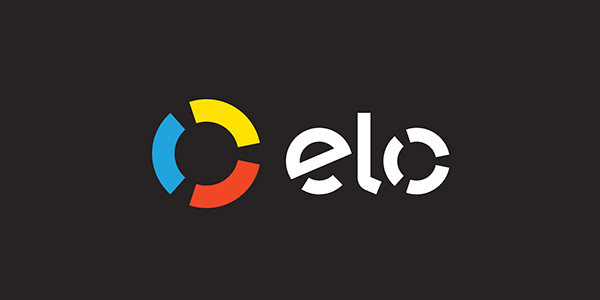



Elo is a pure domestic card brand in Brazil and only allows for transactions in Brazilian Real currency. Elo results from a partnership of three of the largest banks in Brazil: Banco do Brasil, Bradesco and CAIXA. The Elo brand supports credit, debit, and prepaid card transactions. More than 50 million Elo cards have been issued to date. The Elo credit card supports so-called 'installments' that allows the shopper to spread their payments for online purchases over a certain period of time. Cielo, one of the largest merchant acquirers in Brazil, allows ecommerce merchants to accept Elo in their online store. Most of the Brazilian and international Payment Service Providers are connected to Cielo to allow its customer to accept Elo online. Please find below all Payment Service Providers that enable merchants to accept Elo in their webshop.


The competition circulates around the loyalty of customers and the precise prediction of the same is the main judging criteria.

The notebook here comprises of basic Exploratory Data Analysis and then some deep dive into particular customer transactions and then the final prediction of the loyalty score on basis of the various features from the different datasets in consideration

Importing Libraries

In [ ]:
from sklearn import model_selection, preprocessing, metrics
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from pandas import get_dummies
import lightgbm as lgb
import plotly.graph_objs as go
import plotly.offline as py
import xgboost as xgb
import matplotlib.pyplot as plt
import pandas_profiling as pp
import pandas as pd
import numpy as np
import matplotlib
import warnings
import sklearn
import scipy
import numpy
import json
import sys
import csv

%matplotlib inline

In [ ]:
#Loading Train and Test Data
df_train = pd.read_csv('../input/train.csv', parse_dates=["first_active_month"] )
df_test = pd.read_csv('../input/test.csv' ,parse_dates=["first_active_month"] )
df_merchants=pd.read_csv('../input/merchants.csv')
df_new_merchant_transactions=pd.read_csv('../input/new_merchant_transactions.csv')
df_historical_transactions = pd.read_csv("../input/historical_transactions.csv")

In [ ]:
sample_submission = pd.read_csv("../input/sample_submission.csv")

In [ ]:
sample_submission.head()

* The final recommendation is the above target value or the loyalty score for the Elo Platform.

**Pandas Profiling package has been used below for taking the profile report of the datasets**

In [ ]:
pp.ProfileReport(df_train)

In [ ]:
pp.ProfileReport(df_test)

In [ ]:
pp.ProfileReport(df_merchants)

In [ ]:
pp.ProfileReport(df_new_merchant_transactions)

In [ ]:
#Missing Data Analysis on train set
total = df_train.isnull().sum().sort_values(ascending = False)
percent = (df_train.isnull().sum()/df_train.isnull().count()*100).sort_values(ascending = False)
missing_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percentage'])
missing_data.head(20)

In [ ]:
#Missing Data Analysis on test set
total = df_test.isnull().sum().sort_values(ascending = False)
percent = (df_test.isnull().sum()/df_test.isnull().count()*100).sort_values(ascending = False)
missing_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percentage'])
missing_data.head(20)

The above analysis signifies that there are no missing values in the train and test set

In [ ]:
df_train.target.plot.hist()

The above plot signifies that most of the values of the target variable are between -9 to +9 .

There is an outlier value around -30

In [ ]:
# Code reference from https://www.kaggle.com/sudalairajkumar/simple-exploration-notebook-elo
# SRK - Simple Exploration Notebook

import seaborn as sns

cnt_srs = df_train['first_active_month'].dt.date.value_counts()
cnt_srs = cnt_srs.sort_index()
plt.figure(figsize=(14,6))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color='green')
plt.xticks(rotation='vertical')
plt.xlabel('First active month', fontsize=12)
plt.ylabel('Number of cards', fontsize=12)
plt.title("First active month count in train set")
plt.show()

cnt_srs = df_test['first_active_month'].dt.date.value_counts()
cnt_srs = cnt_srs.sort_index()
plt.figure(figsize=(14,6))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color='green')
plt.xticks(rotation='vertical')
plt.xlabel('First active month', fontsize=12)
plt.ylabel('Number of cards', fontsize=12)
plt.title("First active month count in test set")
plt.show()

In [ ]:
df_train.corr()

*** From the above correlation matrix , it is apparent that the features have very less correlation with target value.
Feature 3 has the least correlation as it is closest to 0 and the Feature_1 and Feature_2 have a little negative correlation**

Only Feature 2 and Feature 1 are being converted to numerical values as Feature 3 will not impact the target score much because of negative correlation

In [ ]:
df_train = pd.get_dummies(df_train, columns=['feature_1', 'feature_3'])
df_test = pd.get_dummies(df_test, columns=['feature_1', 'feature_3'])
df_train.head()

**Basic EDA on Historical and New_merchant files**

Top 10 cards with highest number of transactions in historical dataset

In [ ]:
df_card_history  = df_historical_transactions['card_id'].value_counts().head(10)
df_card_history

In [ ]:
df_card_history_authorized  = df_historical_transactions['authorized_flag'].value_counts()
df_card_history_authorized

In [ ]:
df_non_authorized = df_historical_transactions[df_historical_transactions['authorized_flag'] == "N"]
df_non_authorized

In [ ]:
df_card_unauth  = df_non_authorized['card_id'].value_counts()
df_card_unauth.head(10)

The below 2 card_ids have the most unauthorized transactions


**C_ID_5ea401d358 ** --------- 
** C_ID_3d3dfdc692  **

In [ ]:
df_card_1_unauth= df_non_authorized[df_non_authorized['card_id']=="C_ID_5ea401d358"]
df_card_2_unauth = df_non_authorized[df_non_authorized['card_id']=="C_ID_3d3dfdc692"]

Below are the findings for the merchants where these cards have done the  most unauthorized transactions

In [ ]:
df_card_1_merch = df_card_1_unauth['merchant_id'].value_counts()
df_card_1_merch.head(10)

"C_ID_5ea401d358" has the most unauthorized transactions at " M_ID_9fa00da7b2 "    

In [ ]:
df_card_1_merch = df_card_2_unauth['merchant_id'].value_counts()
df_card_1_merch.head(10)

"C_ID_3d3dfdc692" has the most unauthorized transactions at  "M_ID_79692349d6"    

**Top 10 cards with highest number of transactions in new merchant transactions dataset**

In [ ]:
df_card_new  = df_new_merchant_transactions['card_id'].value_counts().head(10)
df_card_new

In [ ]:
df_non_authorized = df_new_merchant_transactions[df_new_merchant_transactions['authorized_flag'] == "N"]
df_non_authorized

***All the transactions in the New Merchant transactions are authorized transactions. **

Moving on to the Historical and new merchant transactions table
The most interesting feature in transactions table seems to be the `purchase_amount`for a particular card_id 

Ideally the values should have been positive , but because the values have been normalized the data is different from expectation . Also,there should have been some integers in it's distribution which is obviously not the case here!

In [ ]:
df_new_merchant_transactions.head()

In [ ]:
df_new_merchant_transactions['purchase_amount_integer'] = df_new_merchant_transactions.purchase_amount.apply(lambda x: x == np.round(x))
print(df_new_merchant_transactions.groupby('purchase_amount_integer')['card_id'].count())

The above code depicts that none of the purchase amount values are integers. 

Some modification is required to make the data consistent which can then be consumed in the model for better predictions.

The below code snippet has been referenced from :
https://www.kaggle.com/raddar/towards-de-anonymizing-the-data-some-insights

In [ ]:
df_new_merchant_transactions['purchase_amount_new'] = np.round(df_new_merchant_transactions['purchase_amount'] / 0.00150265118 + 497.06,8)

In [ ]:
#rounding off two decimal places
df_new_merchant_transactions['purchase_amount_new'] = np.round(df_new_merchant_transactions['purchase_amount'] / 0.00150265118 + 497.06,2)

df_new_merchant_transactions['purchase_amount_integer'] = df_new_merchant_transactions.purchase_amount_new.apply(lambda x: x == np.round(x))
print(df_new_merchant_transactions.groupby('purchase_amount_integer')['card_id'].count())

In [ ]:
df_new_merchant_transactions.groupby('purchase_amount_new')['card_id'].count().reset_index(name='count').sort_values('count',ascending=False).head(100)

Since the above data has some **integer values** and some  with "** 0.55 and 0.99 **" after the decimal places, henceforth the "**purchase amount**" can be considered as the money spent on the transaction


* Converting the categorical data to numerical values with the help of **get_dummies** function from the pandas library

* Since there are only 2 levels in **authorized flag** and **category_1** , henceforth they have been mapped to binary values

In [ ]:
df_historical_transactions = pd.get_dummies(df_historical_transactions, columns=['category_2', 'category_3'])
df_historical_transactions['authorized_flag'] = df_historical_transactions['authorized_flag'].map({'Y': 1, 'N': 0})
df_historical_transactions['category_1'] = df_historical_transactions['category_1'].map({'Y': 1, 'N': 0})

df_historical_transactions.head()

In [ ]:
df_historical_transactions['purchase_amount_integer'] = df_historical_transactions.purchase_amount.apply(lambda x: x == np.round(x))
print(df_historical_transactions.groupby('purchase_amount_integer')['card_id'].count())

In [ ]:
#df_historical_transactions['purchase_amount_new'] = np.round(df_historical_transactions['purchase_amount'] / 0.00150265118 + 497.06,8)
df_historical_transactions['purchase_amount_new'] = np.round(df_historical_transactions['purchase_amount'] / 0.00150265118 + 497.06,2)
df_historical_transactions['purchase_amount_integer'] = df_historical_transactions.purchase_amount_new.apply(lambda x: x == np.round(x))
print(df_historical_transactions.groupby('purchase_amount_integer')['card_id'].count())

In [ ]:
df_historical_transactions.groupby('purchase_amount_new')['card_id'].count().reset_index(name='count').sort_values('count',ascending=False).head(100)

Since the above data too has some **integer values** and some  with "**.50 and 0.99**" after the decimal places, henceforth the "**purchase amount**" can be confirmed as the money spent on the transaction


In [ ]:
del df_historical_transactions['purchase_amount_integer']

In [ ]:
df_historical_transactions.dtypes

In [ ]:

def aggregate_transactions(trans, prefix):  
    trans.loc[:, 'purchase_date'] = pd.DatetimeIndex(trans['purchase_date']).\
                                      astype(np.int64) * 1e-9
    
    agg_func = {
        'authorized_flag': ['sum', 'mean'],
        'category_1': ['mean'],
        'category_2_1.0': ['mean'],
        'category_2_2.0': ['mean'],
        'category_2_3.0': ['mean'],
        'category_2_4.0': ['mean'],
        'category_2_5.0': ['mean'],
        'category_3_A': ['mean'],
        'category_3_B': ['mean'],
        'category_3_C': ['mean'],
        'merchant_id': ['nunique'],
        'purchase_amount_new': ['sum', 'mean', 'max', 'min', 'std'],
        'installments': ['sum', 'mean', 'max', 'min', 'std'],
        'purchase_date': [np.ptp],
        'month_lag': ['min', 'max']
    }
    agg_trans = trans.groupby(['card_id']).agg(agg_func)
    agg_trans.columns = [prefix + '_'.join(col).strip() 
                           for col in agg_trans.columns.values]
    agg_trans.reset_index(inplace=True)
    
    df = (trans.groupby('card_id')
          .size()
          .reset_index(name='{}transactions_count'.format(prefix)))
    
    agg_trans = pd.merge(df, agg_trans, on='card_id', how='left')
    
    return agg_trans

In [ ]:
###### Aggregate transaction function on the historical transaction ######

import gc
merch_hist = aggregate_transactions(df_historical_transactions, prefix='hist_')

del df_historical_transactions
gc.collect()
df_train = pd.merge(df_train, merch_hist, on='card_id',how='left')
df_test = pd.merge(df_test, merch_hist, on='card_id',how='left')

del merch_hist
gc.collect()
df_train.head()


* Similar to the historical transaction dataset, the categorical variables from the new merchant dataset are also converted with the below code snippet with the help of **get_dummies** function from the pandas library

* Since there are only 2 levels in **authorized flag** and **category_1** , henceforth they have been mapped to binary values

In [ ]:
df_new_merchant_transactions = pd.get_dummies(df_new_merchant_transactions, columns=['category_2', 'category_3'])
df_new_merchant_transactions['authorized_flag'] = df_new_merchant_transactions['authorized_flag'].map({'Y': 1, 'N': 0})
df_new_merchant_transactions['category_1'] = df_new_merchant_transactions['category_1'].map({'Y': 1, 'N': 0})

df_new_merchant_transactions.head()

In [ ]:
######Aggregate transaction function on the new merchant transaction ######

merch_new = aggregate_transactions(df_new_merchant_transactions, prefix='new_')
del df_new_merchant_transactions
gc.collect()
df_train = pd.merge(df_train, merch_new, on='card_id',how='left')
df_test = pd.merge(df_test, merch_new, on='card_id',how='left')

del merch_new
gc.collect()
df_train.head()

In [ ]:
###### Dropping 3 columns ######

target = df_train['target']
drops = ['card_id', 'first_active_month', 'target']
use_cols = [c for c in df_train.columns if c not in drops]
features = list(df_train[use_cols].columns)
df_train[features].head()

In [ ]:
print(df_train[features].shape)
print(df_test[features].shape)

In [ ]:
df_train.corr()

Cross-validation is a resampling procedure used to evaluate machine learning models on a limited data sample.

The general procedure is as follows:
1. Shuffle the dataset randomly.
2. Split the dataset into k groups
3. For each unique group:
    1. Take the group as a hold out or test data set
    2. Take the remaining groups as a training data set
    3. Fit a model on the training set and evaluate it on the test set
4. Retain the evaluation score and discard the model
5. Summarize the skill of the model using the sample of model evaluation scores


References: https://machinelearningmastery.com/k-fold-cross-validation/

In [ ]:
#### Utilizing KFold Cross Validator ####

from sklearn.model_selection import KFold

Light GBM is a gradient boosting framework that uses tree based learning algorithm.

Light GBM grows tree vertically while other algorithm grows trees horizontally meaning that Light GBM grows tree leaf-wise while other algorithm grows level-wise. It will choose the leaf with max delta loss to grow. When growing the same leaf, Leaf-wise algorithm can reduce more loss than a level-wise algorithm.

Light GBM works this way
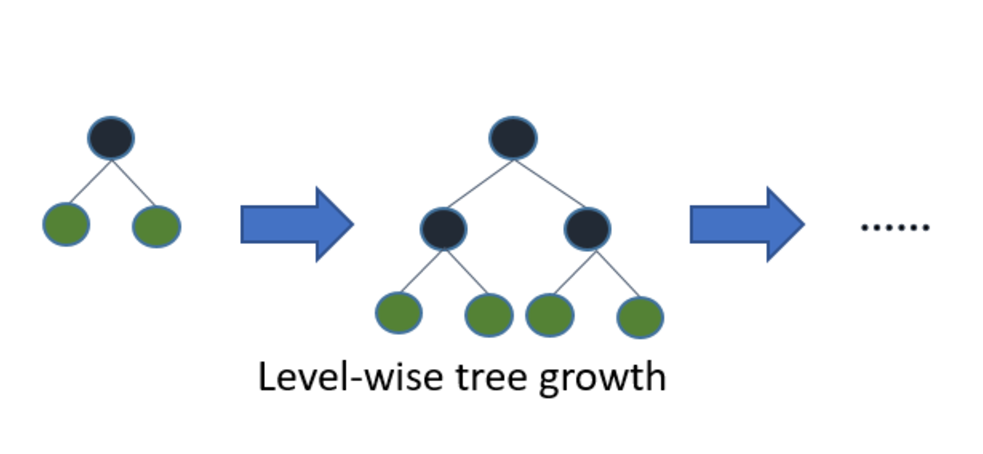

Other algorithms works this way
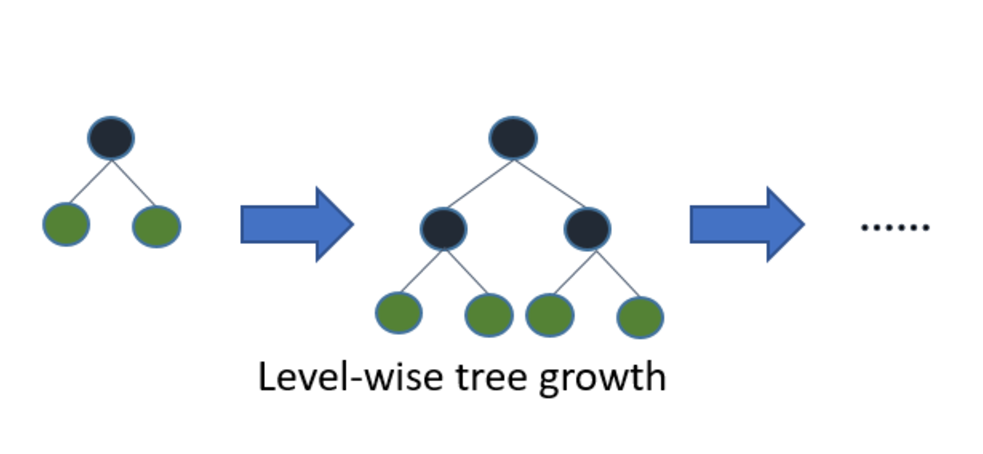


References : https://medium.com/@pushkarmandot/https-medium-com-pushkarmandot-what-is-lightgbm-how-to-implement-it-how-to-fine-tune-the-parameters-60347819b7fc



In [ ]:
###LGB model detals for different parameters referenced from  the below notebook
####https://www.kaggle.com/peterhurford/you-re-going-to-want-more-categories-lb-3-737

param = {'num_leaves': 50,
         'min_data_in_leaf': 30, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.005,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1}

################# 5  fold cross validation #################


### Splitting the dataset into 5 folds for validation
folds = KFold(n_splits=5, shuffle=True, random_state=15)
oof_5 = np.zeros(len(df_train))
predictions = np.zeros(len(df_test))



for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train.values, target.values)):
    print('-')
    print("Fold {}".format(fold_ + 1))
    trn_data = lgb.Dataset(df_train.iloc[trn_idx][features], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(df_train.iloc[val_idx][features], label=target.iloc[val_idx])

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds=100)
    oof_5[val_idx] = clf.predict(df_train.iloc[val_idx][features], num_iteration=clf.best_iteration)
    predictions += clf.predict(df_test[features], num_iteration=clf.best_iteration) / folds.n_splits

**Calculating the mean squared error with the help light gradient booster model**

In [ ]:
print('5 Fold Cross Validation - lgb - ', np.sqrt(mean_squared_error(oof_5, target)))


In [ ]:
###LGB model detals for different parameters referenced from  the below notebook
####https://www.kaggle.com/peterhurford/you-re-going-to-want-more-categories-lb-3-737

param = {'num_leaves': 50,
         'min_data_in_leaf': 30, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.005,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1}



################# 10  fold cross validation #################



### Splitting the dataset into 10 folds for validation
folds = KFold(n_splits=10, shuffle=True, random_state=15)
oof_10 = np.zeros(len(df_train))
predictions = np.zeros(len(df_test))



for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train.values, target.values)):
    print('-')
    print("Fold {}".format(fold_ + 1))
    trn_data = lgb.Dataset(df_train.iloc[trn_idx][features], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(df_train.iloc[val_idx][features], label=target.iloc[val_idx])

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds=100)
    oof_10[val_idx] = clf.predict(df_train.iloc[val_idx][features], num_iteration=clf.best_iteration)
    predictions += clf.predict(df_test[features], num_iteration=clf.best_iteration) / folds.n_splits

In [ ]:
print('10 Fold Cross Validation - lgb - ', np.sqrt(mean_squared_error(oof_10, target)))


In [ ]:
sub_df = pd.read_csv('../input/sample_submission.csv')
sub_df["target"] =  predictions #0.5 * predictions_lgb + 0.5 * predictions_xgb
sub_df.to_csv("submission.csv", index=False)

In [ ]:
sub_df.tail(5)